# Earth Quake Prediction

## Overview
Every year many lives are lost and infastructure worh billions of dollars is destroyed in earh quakes. What if we could predict when an earh quake will occur so that this demage can be avoided or reduced.

In this project we predict the time remaining before laboratory earthquakes occurs from real-time seismic data.

For details about the kaggle challene please visit the below link;

https://www.kaggle.com/c/LANL-Earthquake-Prediction

## Data Description

We will use the (acoustic_data) input signal to predict the time remaining before the next laboratory earthquake (time_to_failure). Please note that all this data has been generated in lab. If you want to know how a laboratory earth quake happens then please check out the below youtube video.

https://www.youtube.com/watch?v=m_dBwwDJ4uo

The training data is a single, continuous segment of experimental data. The test data consists of a folder containing many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file.

For each seg_id in the test folder, we have to predict a single time_to_failure corresponding to the time between the last row of the segment and the next laboratory earthquake.

**Data Fields**

* acoustic_data - the seismic signal [int16]
* time_to_failure - the time (in seconds) until the next laboratory earthquake [float64]
* seg_id - the test segment ids for which predictions should be made (one prediction per segment)

### Package Imports and EDA

In [1]:
#making the imports / ignore warnings
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("../input"))

['earth-quake-images', 'LANL-Earthquake-Prediction']


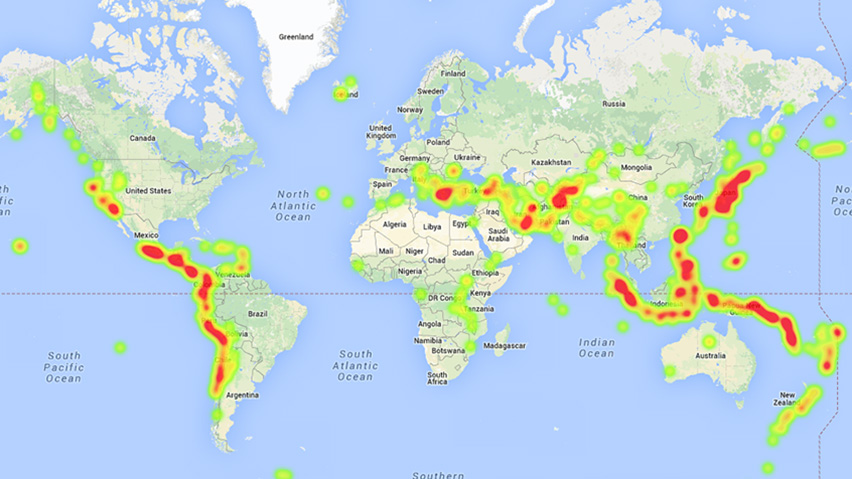

In [2]:
# although not related I will show some images to get an idea about where the most earthquakes occur
global_earth_quakes = Image('../input/earth-quake-images/global_earth_quakes.jpg', width = 1000)
global_earth_quakes

As we can see in this heat map that most of the earth quakes happen in Asia Pacific and South America Region.

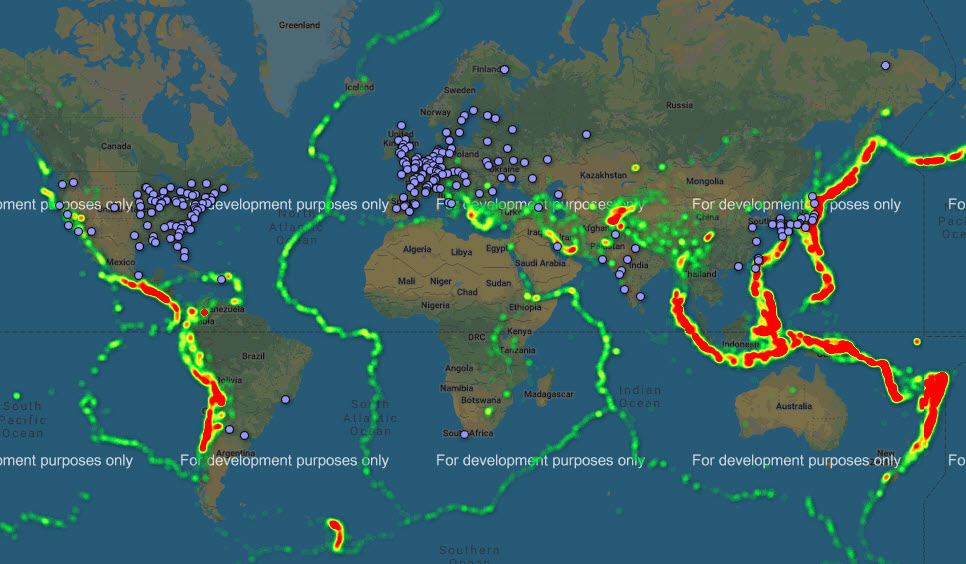

In [3]:
#image showing nuclear plant locations and earth quake hot zones
nuclear_plants_locations = Image('../input/earth-quake-images/earth_quakes_nuclear_p_locations.jpg')
nuclear_plants_locations

From this image we can tell that nuclear plants located in Japan are at risk (if they get some demage in earth quake). Just as a precaution nuclear facilites should not be developed in high risk areas.

### Reading the training file

In [4]:
#reading the training file (warning: huge size) specify data types to save memory
#I will be using garbage collection frequently to clear the memory

data_type = {'acoustic_data': np.int16, 'time_to_failure': np.float32}
train = pd.read_csv('../input/LANL-Earthquake-Prediction/train.csv', dtype=data_type)
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [5]:
#garbage collection
gc.collect()

15

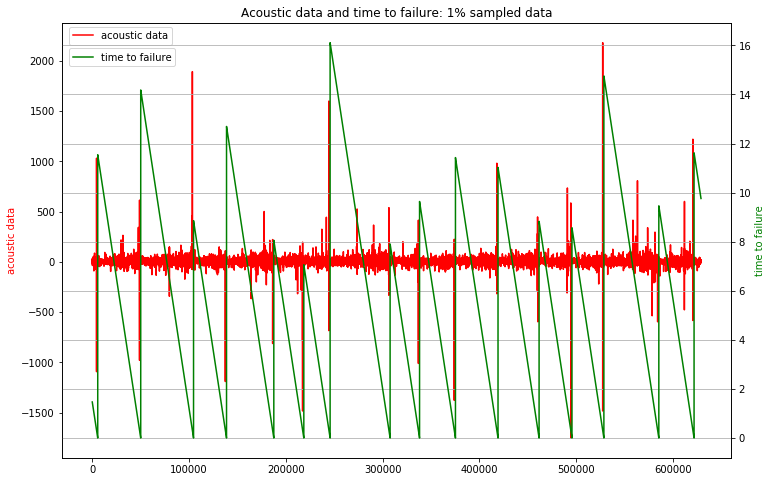

In [6]:
# plot to see the relation between given variable and target variable

train_ad_sample_df = train['acoustic_data'].values[::1000]
train_ttf_sample_df = train['time_to_failure'].values[::1000]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='g')
    ax2.set_ylabel('time to failure', color='g')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)


In [7]:
#delete the old frame
del train_ad_sample_df
del train_ttf_sample_df

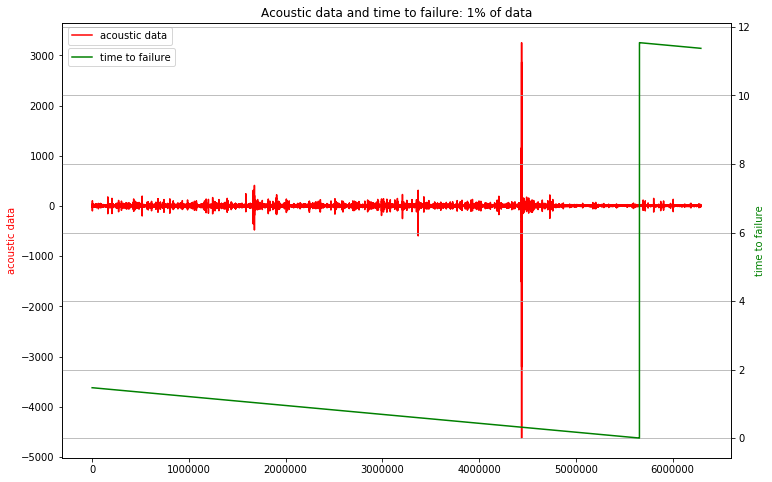

In [8]:
#plot to show zoomed in view

train_ad_sample_df = train['acoustic_data'].values[:6291455]
train_ttf_sample_df = train['time_to_failure'].values[:6291455]
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% of data")
del train_ad_sample_df
del train_ttf_sample_df

We can see that there are series of little jumps in the acoustic data and then there is a big spike which is followed by failure event. 

In [9]:
#garbage collection
gc.collect()

9847

# Feature Enineering

In [10]:
#lets create a function to generate some statistical features based on the training data
# this is necessay as only one variable [acoustic data] is given to us in training set

def generate_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [11]:
# check the head
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [12]:
# lets apply feature generation function
# also we will read the training file in chunks. chunk size specifies the number of rows which pandas will 
# read in one chunk

c_s = 10 ** 6
train = pd.read_csv('../input/LANL-Earthquake-Prediction/train.csv', iterator=True, chunksize= c_s, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = generate_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [13]:
#describe the data

X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000
mean,4.519426,7.447321,-352.041270,372.665079,197.911797,0.187172,-10.787317,-2.096825,11.157143,19.857175,395.915873,5.546469,6.689019
std,0.227468,7.726336,629.954142,648.267855,362.610600,0.958291,5.905677,1.320677,1.325693,5.917177,707.557909,0.781491,7.714880
min,3.825053,3.266844,-5515.000000,64.000000,15.517318,-7.923130,-42.000000,-7.000000,9.000000,11.000000,66.000000,4.355765,2.927055
25%,4.372792,4.720289,-279.750000,167.250000,63.136608,-0.008884,-14.000000,-3.000000,10.000000,15.000000,173.000000,5.088079,4.116544
50%,4.527324,5.861961,-201.000000,215.000000,91.457284,0.130532,-10.500000,-2.000000,11.000000,20.000000,224.000000,5.398901,5.060474
75%,4.673295,7.116524,-149.000000,297.750000,148.987620,0.305890,-6.000000,-1.000000,12.000000,23.000000,316.000000,5.792956,6.113660
max,5.218091,59.710732,-66.000000,5444.000000,2918.871902,8.457422,-2.000000,0.000000,17.000000,52.000000,5515.000000,10.523335,59.165763


In [14]:
#garbage collection
gc.collect()

70

# Catboost 

CatBoost is an algorithm for gradient boosting on decision trees. It is developed by Yandex researchers and engineers (Russian), and is used at Yandex for search, recommendation systems, personal assistant, self-driving cars, weather prediction and many other tasks. It is in open-source and can be used by anyone now.

More details @

https://catboost.ai/docs/concepts/about.html


In [15]:
# just a base line for cat boost
# get the best score without hyper parameter tuning

from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 0.6275330926825007}}

# Support Vector Machines

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points. It seems line it is for classification tasks but 
it can be used for regression also. 

More details @

https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47


In [16]:
# now lets try SVM with rbf kernel + grid search for hyper paramter tuning

from sklearn.svm import NuSVR, SVR
from sklearn.model_selection import KFold

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

folds = KFold(n_splits= 5, shuffle= True, random_state= 101)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv= folds, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -1.8185
{'C': 2, 'gamma': 0.1}


In [17]:
#garbage collection
gc.collect()

6

# Neural Nets

Go through the below link to get an idead about the NNs. 

https://towardsdatascience.com/machine-learning-for-beginners-an-introduction-to-neural-networks-d49f22d238f9

In [18]:
#making the imports
#TQDM is a progress bar library with good support for nested loops and Jupyter/IPython notebooks.

from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from tqdm import tqdm

Using TensorFlow backend.


In [19]:
#reading the training file with data types int16 and float32

data_type = {'acoustic_data': np.int16, 'time_to_failure': np.float32}
train_data = pd.read_csv('../input/LANL-Earthquake-Prediction/train.csv', dtype=data_type)
train_data.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [20]:
#garbage collection
gc.collect()

37

In [21]:
# making the training file ready to be fed into a NN

rows = 150000
segments = int(np.floor(train_data.shape[0] / rows))

X_train = pd.DataFrame(index = range(segments),dtype = np.float32,columns = ['mean','std','99quat','50quat','25quat','1quat'])
y_train = pd.DataFrame(index = range(segments),dtype = np.float32,columns = ['time_to_failure'])

In [22]:
# generating the features like mean/std/quantiles

for segment in tqdm(range(segments)):
    x = train_data.iloc[segment*rows:segment*rows+rows]
    y = x['time_to_failure'].values[-1]
    x = x['acoustic_data'].values
    X_train.loc[segment,'mean'] = np.mean(x)
    X_train.loc[segment,'std']  = np.std(x)
    X_train.loc[segment,'99quat'] = np.quantile(x,0.99)
    X_train.loc[segment,'50quat'] = np.quantile(x,0.5)
    X_train.loc[segment,'25quat'] = np.quantile(x,0.25)
    X_train.loc[segment,'1quat'] =  np.quantile(x,0.01)
    y_train.loc[segment,'time_to_failure'] = y

100%|██████████| 4194/4194 [00:29<00:00, 143.26it/s]


In [23]:
#using standard scaler to scale the data

scaler = StandardScaler()
X_scaler = scaler.fit_transform(X_train)

In [24]:
#garbage collection
gc.collect()

7

In [25]:
#compiling the sequential model. Simple model with input shape 6 and activation function rectified linear
# as it is a regression task so use Mean Absolute Error as measuring matrix
# will use default optimizer adam

model = Sequential()
model.add(Dense(32,input_shape = (6,),activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1))
model.compile(loss = 'mae',optimizer = 'adam')

In [26]:
#train the model (30 epochs)
#feed in the scaled training data

model.fit(X_scaler,y_train.values.flatten(),epochs = 30)

Epoch 1/30
4194/4194 [==============================] - 4s 967us/step - loss: 3.5457
Epoch 2/30
4194/4194 [==============================] - 0s 85us/step - loss: 2.2395
Epoch 3/30
4194/4194 [==============================] - 0s 85us/step - loss: 2.2022
Epoch 4/30
4194/4194 [==============================] - 0s 88us/step - loss: 2.1924
Epoch 5/30
4194/4194 [==============================] - 0s 86us/step - loss: 2.1874
Epoch 6/30
4194/4194 [==============================] - 0s 85us/step - loss: 2.1919
Epoch 7/30
4194/4194 [==============================] - 0s 88us/step - loss: 2.1807
Epoch 8/30
4194/4194 [==============================] - 0s 86us/step - loss: 2.1869
Epoch 9/30
4194/4194 [==============================] - 0s 84us/step - loss: 2.1800
Epoch 10/30
4194/4194 [==============================] - 0s 89us/step - loss: 2.1735
Epoch 11/30
4194/4194 [==============================] - 0s 86us/step - loss: 2.1738
Epoch 12/30
4194/4194 [==============================] - 0s 85us/step - l

In [27]:
#reading the submission file from input directory

sub_data = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv',index_col = 'seg_id')

In [28]:
#building the test data frame using same columns as X_train

X_test = pd.DataFrame(columns = X_train.columns,dtype = np.float32,index = sub_data.index)

In [29]:
#feature generation for test data

for seq in tqdm(X_test.index):
    test_data = pd.read_csv('../input/LANL-Earthquake-Prediction/test/'+seq+'.csv')
    x = test_data['acoustic_data'].values
    X_test.loc[seq,'mean'] = np.mean(x)
    X_test.loc[seq,'std']  = np.std(x)
    X_test.loc[seq,'99quat'] = np.quantile(x,0.99)
    X_test.loc[seq,'50quat'] = np.quantile(x,0.5)
    X_test.loc[seq,'25quat'] = np.quantile(x,0.25)
    X_test.loc[seq,'1quat'] =  np.quantile(x,0.01)

100%|██████████| 2624/2624 [00:59<00:00, 43.91it/s]


In [30]:
#garbage collect
gc.collect()

658

In [31]:
#scale the test data using pre-defined scaler

X_test_scaler = scaler.transform(X_test)

In [32]:
#making the predictions
pred = model.predict(X_test_scaler)

In [33]:
sub_data.head()

,time_to_failure
seg_id,
seg_00030f,0
seg_0012b5,0
seg_00184e,0
seg_003339,0
seg_0042cc,0


Will not submit this file. Lets wait for Xgboost with hyper parameter tuning to give us the best predictions. 

## Xgboost

XGBoost is well known to provide better solutions than other machine learning algorithms. In fact, since its inception, it has become the "state-of-the-art” machine learning algorithm to deal with structured data.

For hyper parameter tuning of xgboost go through the below link:

https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e

In [34]:
#import xgboost (we will use regressor)

import xgboost as xgb

In [35]:
#use the same already scaled X and y from NN part

xgb_model = xgb.XGBRegressor()

xgb_model.fit(X_scaler,y_train.values)

[14:37:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [36]:
#predictions without hyper paramter tuning

pred = xgb_model.predict(X_test_scaler)

In [37]:
# hyperparameter tuning with XGBoost (will take some time to run)

# creating a KFold object with 3 splits

folds = KFold(n_splits= 3, shuffle= True, random_state= 101)

# specify range of hyperparameters
param_grid = {'learning_rate': [0.01, 0.1, 0.2, 0.3], 
             'subsample': [0.3, 0.6, 0.9, 1],
              'n_estimators' : [5, 10, 15, 20],
              'max_depth' :[2,4,6,8]          
             }          


# specify model
xgb_model = xgb.XGBRegressor()

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring='neg_mean_absolute_error', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True, 
                        n_jobs= -1)      

In [38]:
#train the model
model_cv.fit(X_scaler,y_train.values)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:    7.6s


[14:38:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed:   19.4s finished


GridSearchCV(cv=KFold(n_splits=3, random_state=101, shuffle=True),
             error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthre...
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.3],
   

In [39]:
# printing the optimal accuracy score and hyperparameters
print('We can get neg_mean_absolute_error:',model_cv.best_score_,'using',model_cv.best_params_)

We can get neg_mean_absolute_error: -2.2015762329101562 using {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 10, 'subsample': 0.9}


In [40]:
# define model with best paramters and train plus make predictions

xgb_model = xgb.XGBRegressor(learning_rate= 0.2, max_depth= 4, n_estimators= 10, subsample= 0.9)

xgb_model.fit(X_scaler,y_train.values)

pred = xgb_model.predict(X_test_scaler)

# read the submission file and populate it with predictions

sample_submission = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv')
sample_submission['time_to_failure'] = pred

print(sample_submission.shape)

print('\n')

sample_submission.head()

[14:38:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
(2624, 2)




,seg_id,time_to_failure
0,seg_00030f,5.087132
1,seg_0012b5,4.342933
2,seg_00184e,3.852653
3,seg_003339,7.427964
4,seg_0042cc,5.149960


In [41]:
#write to csv file

sample_submission.to_csv('Final_EQ_sub.csv', index=False)